# Import Packages

In [1]:
import pystac_client
import stackstac
import matplotlib.pyplot as plt
import geopandas as gpd
import requests
import numpy as np
import json
import os
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import sys
from tqdm import tqdm
import time
import rioxarray as rio


# Install pystac module in anaconda

In [11]:
!{sys.executable} -m pip install pystac

In [2]:
hdd_path = r"D:\Geospatial_Pessoal"

In [3]:
aoi_path = fr"{hdd_path}\STAC_py\pedrogao_grande_area_ardida_2017.geojson"

# Load the GeoJSON file
with open(aoi_path) as f:
    geojson_aoi = json.load(f)

# Extract all coordinates from the polygon

coordinates = geojson_aoi['features'][0]['geometry']['coordinates'][0]  # Assuming the first feature is the AOI

# Define the bounds from the GeoJSON for stacking

lon_min = min(coord[0] for coord in coordinates)
lat_min = min(coord[1] for coord in coordinates)
lon_max = max(coord[0] for coord in coordinates)
lat_max = max(coord[1] for coord in coordinates)

# Flatten the list of coordinates if you have a polygon (list of lists)
points = [(coord[1], coord[0]) for coord in coordinates]  # (lat, lon) tuples


In [4]:
start_date = "2017-01-01" 
end_date = "2017-07-31"
time_range = f"{start_date}/{end_date}"

# Search Sentinel 2 level 2 Images with cloud filtering 

In [5]:
# Set up the Sentinel STAC API URL
sentinel_search_url = "https://earth-search.aws.element84.com/v1"
sentinel_stac_client = pystac_client.Client.open(sentinel_search_url)

items = sentinel_stac_client.search(
    intersects=geojson_aoi['features'][0]['geometry'],  # Use the geometry directly
    collections=["sentinel-2-l2a"],
    datetime=time_range,
    query={"eo:cloud_cover": {"lte": 10}}  # Filter by cloud coverage. lte = less than or equal to
).item_collection()

print("Number of items found:", len(items))

Number of items found: 19


In [6]:
sentinel_stack = stackstac.stack(items, assets=["red", "nir", "scl"],
                          gdal_env=stackstac.DEFAULT_GDAL_ENV.updated(
                               {'GDAL_HTTP_MAX_RETRY': 3,
                                'GDAL_HTTP_RETRY_DELAY': 5,
                               }),
                          epsg=4326, chunksize=(1, 1, 50, 50)).to_dataset(
       dim='band')

# This length number represents the number  of assets (bands) that are to be extracted
# len(sentinel_stack)

sentinel_stack


<xarray.Dataset> Size: 106GB
Dimensions:                                  (time: 19, y: 11060, x: 20981,
                                              band: 3)
Coordinates: (12/51)
  * time                                     (time) datetime64[ns] 152B 2017-...
    id                                       (time) <U24 2kB 'S2A_29TNE_20170...
  * x                                        (x) float64 168kB -10.18 ... -7.702
  * y                                        (y) float64 88kB 40.65 ... 39.65
    earthsearch:s3_path                      (time) <U79 6kB 's3://sentinel-c...
    s2:medium_proba_clouds_percentage        (time) float64 152B 2.341 ... 0....
    ...                                       ...
    raster:bands                             (band) object 24B {'nodata': 0, ...
    gsd                                      (band) object 24B 10 10 None
    common_name                              (band) object 24B 'red' 'nir' None
    center_wavelength                        (band) object 24B 0.665 0.842 None
    full_width_half_max                      (band) object 24B 0.038 0.145 None
    epsg                                     int64 8B 4326
Dimensions without coordinates: band
Data variables:
    red                                      (time, y, x) float64 35GB dask.array<chunksize=(1, 50, 50), meta=np.ndarray>
    nir                                      (time, y, x) float64 35GB dask.array<chunksize=(1, 50, 50), meta=np.ndarray>
    scl                                      (time, y, x) float64 35GB dask.array<chunksize=(1, 50, 50), meta=np.ndarray>
Attributes:
    spec:           RasterSpec(epsg=4326, bounds=(np.float64(-10.183261250575...
    crs:            epsg:4326
    transform:      | 0.00, 0.00,-10.18|\n| 0.00,-0.00, 40.65|\n| 0.00, 0.00,...
    resolution_xy:  (np.float64(0.00011828210482356383), np.float64(9.0088043...

# Download dataset if required

In [57]:
def download_asset(asset_url, local_path):
    try:
        response = requests.get(asset_url, stream=True)
        response.raise_for_status()  # Raises an error for bad responses
        
        # Get total file size for progress tracking
        total_size = int(response.headers.get('content-length', 0))
        
        # Create a tqdm progress bar
        with open(local_path, 'wb') as f:
            with tqdm(total=total_size, unit='B', unit_scale=True, desc=local_path, bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [elapsed: {elapsed} | {rate_fmt}]') as bar:
                downloaded_size = 0
                start_time = time.time()  # Start time for speed calculation
                
                for chunk in response.iter_content(chunk_size=8192):
                    f.write(chunk)
                    downloaded_size += len(chunk)
                    bar.update(len(chunk))
                    
                    # Calculate elapsed time and download speed
                    elapsed_time = time.time() - start_time
                    if elapsed_time > 0:
                        speed = downloaded_size / elapsed_time  # bytes per second
                        bar.set_postfix(speed=f"{speed / 1024:.2f} kB/s")  # Display speed in kB/s
        
        print(f"\nDownloaded: {local_path}")
    except requests.RequestException as e:
        print(f"Failed to download: {asset_url}, error: {str(e)}")
    except Exception as e:
        print(f"An error occurred while downloading {asset_url}: {str(e)}")

In [1]:
# Define the local directory for saving assets
output_directory = fr"{hdd_path}\STAC_py\output" 

assets_to_download = ["red", "nir", "scl"]  # Changed from B04 to red, B08 to nir

# Iterate over filtered_stack items and download assets
for item in items: 
    # Print the item ID and available assets for debugging
    print(f"Processing item: {item.id}")
    print("Available assets:", item.assets.keys())  # Print available asset names

    for asset_name in assets_to_download:
        if asset_name in item.assets:
            asset_url = item.assets[asset_name].href
            print(f"Downloading {asset_name} from {asset_url}")  # Print the URL being downloaded
            local_filename = os.path.join(output_directory, f"{item.id}_{asset_name}.tif")
            download_asset(asset_url, local_filename)
        else:
            print(f"Asset {asset_name} not found in item {item.id}")

print("All downloads completed.")

NameError: name 'hdd_path' is not defined

# Calculate NDVI

In [8]:
sentinel_stack['ndvi'] = xr.where(
    (sentinel_stack['nir'] + sentinel_stack['red']) != 0,
    (sentinel_stack['nir'] - sentinel_stack['red']) / (sentinel_stack['nir'] + sentinel_stack['red']),
    np.nan
)

# Remove attributes that are not time,lat or lan

sentinel_stack = sentinel_stack.drop_vars([c for c in sentinel_stack.coords if not (c in ['time', 'lat', 'lon'])])

In [14]:
aoi = gpd.read_file(fr"{hdd_path}/STAC_py/pedrogao_grande_area_ardida_2017.geojson")

# Set the CRS for the dataset

crs = "EPSG:4326"
crs_number = crs[5:]
sentinel_stack = sentinel_stack.rio.write_crs(fr"{crs}", inplace=True)

# Iterate over the time dimension and export each NDVI layer
for i in range(sentinel_stack.sizes['time']):
    # Extract the timestamp and format it as YYYYMMDD
    time_str = str(sentinel_stack['time'].isel(time=i).dt.strftime('%Y%m%d').values)
    ndvi_slice = sentinel_stack['ndvi'].isel(time=i)
    ndvi_slice = ndvi_slice.rio.set_spatial_dims(x_dim="x", y_dim="y", inplace=True)
    ndvi_clipped = ndvi_slice.rio.clip(aoi.geometry, aoi.crs, drop=True)
    
    output_path = f"{hdd_path}/STAC_py/ndvi_output/NDVI_{time_str}_{crs_number}.tiff"
    ndvi_clipped.rio.to_raster(output_path)

    print(f"Exported clipped NDVI time slice for {time_str} to {output_path}")

Exported clipped NDVI time slice for 20170105 to D:\Geospatial_Pessoal/STAC_py/ndvi_output/NDVI_20170105_4326.tiff
Exported clipped NDVI time slice for 20170105 to D:\Geospatial_Pessoal/STAC_py/ndvi_output/NDVI_20170105_4326.tiff
Exported clipped NDVI time slice for 20170108 to D:\Geospatial_Pessoal/STAC_py/ndvi_output/NDVI_20170108_4326.tiff
Exported clipped NDVI time slice for 20170108 to D:\Geospatial_Pessoal/STAC_py/ndvi_output/NDVI_20170108_4326.tiff
Exported clipped NDVI time slice for 20170115 to D:\Geospatial_Pessoal/STAC_py/ndvi_output/NDVI_20170115_4326.tiff
Exported clipped NDVI time slice for 20170115 to D:\Geospatial_Pessoal/STAC_py/ndvi_output/NDVI_20170115_4326.tiff
Exported clipped NDVI time slice for 20170118 to D:\Geospatial_Pessoal/STAC_py/ndvi_output/NDVI_20170118_4326.tiff
Exported clipped NDVI time slice for 20170118 to D:\Geospatial_Pessoal/STAC_py/ndvi_output/NDVI_20170118_4326.tiff
Exported clipped NDVI time slice for 20170125 to D:\Geospatial_Pessoal/STAC_py/n

In [17]:
# Load NDVI data for the first point (as an example)

first_point = points[0]  # Change to the desired point if needed
y, x = first_point
sentinel_point = sentinel_stack.interp(lon=x, lat=y, method="nearest")


ValueError: Dimensions {'lat', 'lon'} do not exist. Expected one or more of FrozenMappingWarningOnValuesAccess({'time': 19, 'y': 11060, 'x': 20981})

In [18]:
first_point

(39.8568638050615, -8.925611796599247)

In [11]:
# Load the selected data subset
sentinel_point.load()

<xarray.Dataset> Size: 776B
Dimensions:  (time: 19)
Coordinates:
  * time     (time) datetime64[ns] 152B 2017-01-05T11:27:37.242000 ... 2017-0...
Data variables:
    red      (time) float64 152B nan nan nan nan nan nan ... nan nan nan nan nan
    nir      (time) float64 152B nan nan nan nan nan nan ... nan nan nan nan nan
    scl      (time) float64 152B nan nan nan nan nan nan ... nan nan nan nan nan
    ndvi     (time) float64 152B nan nan nan nan nan nan ... nan nan nan nan nan
    x        float64 8B -8.926
    y        float64 8B 39.86
Attributes:
    spec:           RasterSpec(epsg=4326, bounds=(np.float64(-10.183261250575...
    crs:            epsg:4326
    transform:      | 0.00, 0.00,-10.18|\n| 0.00,-0.00, 40.65|\n| 0.00, 0.00,...
    resolution_xy:  (np.float64(0.00011828210482356383), np.float64(9.0088043...

In [12]:
# Transform the Dataset to a DataFrame
sentinel_table = sentinel_point.to_dataframe()
sentinel_table

# Step 2: Filter NDVI values that are out of the valid range (-1 to 1)
sentinel_table = sentinel_table[(sentinel_table['ndvi'] >= -1) & (sentinel_table['ndvi'] <= 1)]

# Step 3: Reset index if needed (optional, depending on how you want to handle the index)
sentinel_table.reset_index(inplace=True)

In [13]:
sentinel_table

,time,red,nir,scl,ndvi,x,y


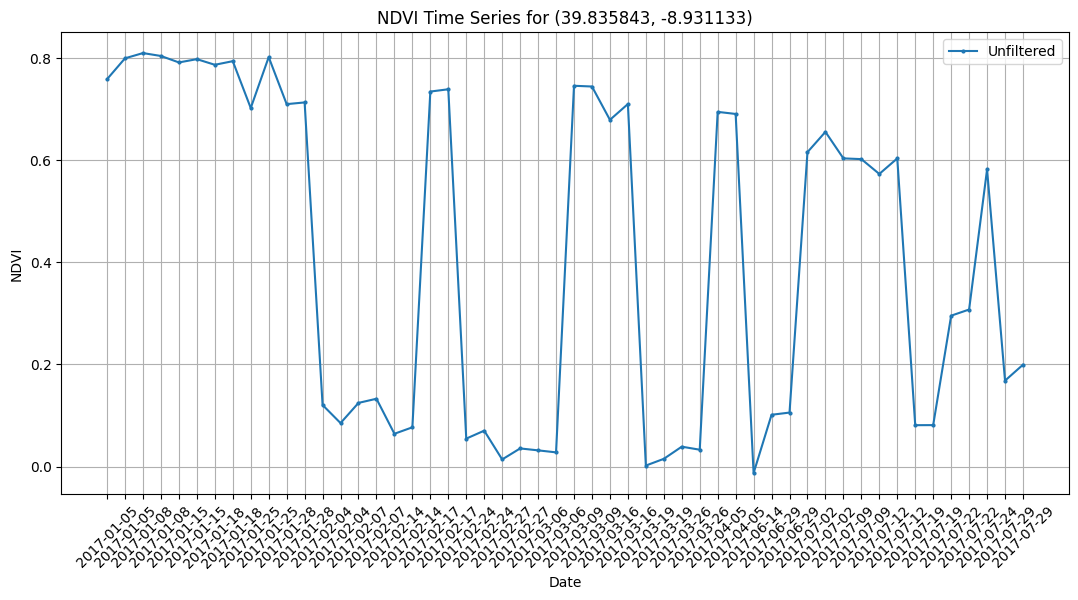

In [38]:
# Plot NDVI through time

plt.figure(figsize=(13, 6))
sentinel_table['ndvi'].plot(label='Unfiltered', marker='o', linestyle='-', markersize=2)

# Set title with coordinates
plt.title(f"NDVI Time Series for ({lat:.6f}, {lon:.6f})")  # Display coordinates with 6 decimal places
plt.xlabel('Date')
plt.ylabel('NDVI')
plt.legend()
plt.grid()
# Format x-axis date labels using the 'time' column for the ticks
plt.xticks(ticks=range(len(sentinel_table)), labels=sentinel_table['time'].dt.strftime('%Y-%m-%d'), rotation=45)

plt.show()